In [1]:
from glob import glob
import datetime

from astropy.table import Table
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scipy.stats import spearmanr
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
from matplotlib.ticker import MultipleLocator

Why do this?

## Gather the data

### HR

+ redshift cut
+ HR cut

In [3]:
HR = pd.read_csv('../data/CampbellHoltzman_mb.tsv', sep='\t', usecols=['SNID', 'redshift', 'hr', 'err_mu'], index_col='SNID')
HR.rename(columns={'err_mu': 'hr uncert'}, inplace=True)
HR = HR[HR['redshift']<0.2]  
HR = HR[HR['hr']<0.7]
HR.describe()

,redshift,hr uncert,hr
count,104.000000,104.000000,104.000000
mean,0.142955,0.078242,-0.022419
std,0.042061,0.016465,0.185333
min,0.045248,0.056201,-0.495474
25%,0.112912,0.065671,-0.151208
50%,0.152131,0.075159,-0.032278
75%,0.180615,0.085572,0.090769
max,0.198704,0.133972,0.497041


### SALT2 parameters (x_1 & c)

In [4]:
t = Table.read('../data/SDSS_Photometric_SNe_Ia.fits')
salt = t['CID','Z','X1','X1_ERR','COLOR','COLOR_ERR'].to_pandas()
salt.columns = salt.columns.str.lower()
salt.rename(columns={'cid': 'SNID', 'z': 'redshift'}, inplace=True)
salt.set_index('SNID', inplace=True)
salt.describe()

,redshift,x1,x1_err,color,color_err
count,752.000000,752.000000,752.000000,752.000000,752.000000
mean,0.294032,-0.006514,0.765859,-0.013105,0.059070
std,0.103553,1.082517,0.506811,0.100019,0.023878
min,0.037069,-2.952440,0.061210,-0.245912,0.024959
25%,0.220188,-0.776738,0.426394,-0.084207,0.041157
50%,0.294489,0.022410,0.702974,-0.019256,0.055565
75%,0.369411,0.793196,1.011968,0.051200,0.073263
max,0.700345,2.887440,8.048070,0.246569,0.195758


### Stellar Mass

In [5]:
galaxy = pd.read_csv('../resources/kcorrect_stellarmass.csv',  usecols=['GAL', 'redshift', 'stellarmass'], index_col='GAL')
galaxy.rename(columns={'redshift': 'gal redshift', 'stellarmass': 'stellar mass'}, inplace=True)
galaxy.describe()

,gal redshift,stellar mass
count,305.000000,3.050000e+02
mean,0.223845,4.177042e+10
std,0.071923,5.006189e+10
min,0.045363,3.521470e+07
25%,0.175242,8.513790e+09
50%,0.236310,2.342800e+10
75%,0.284038,5.800110e+10
max,0.336325,3.486340e+11


### Age

In [6]:
age = pd.read_csv('../resources/ages_campbell.tsv', sep='\t',  skiprows=[1],
                   usecols=['# sn id', 'age'], dtype={'age': np.float64, '# sn id': np.int})
age.rename(columns={'# sn id': 'SNID'}, inplace=True)
age.set_index('SNID', inplace=True)
age.describe()

,age
count,300.000000
mean,4.918252
std,1.953591
min,1.442631
25%,3.385100
50%,4.609988
75%,6.495736
max,9.597481


In [6]:
age_global = pd.read_csv('../resources/ages_campbellG.tsv', sep='\t',  skiprows=[1],
                         usecols=['# sn id', 'age'], dtype={'age': np.float64, '# sn id': np.int})
age_global.rename(columns={'# sn id': 'SNID'}, inplace=True)
age_global.set_index('SNID', inplace=True)
age_global.describe()

,age
count,299.000000
mean,5.060899
std,2.017723
min,0.948003
25%,3.403084
50%,4.836372
75%,6.555893
max,10.454058


### Combine

In [7]:
data = pd.concat([HR, salt, galaxy, age], axis=1)
data.dropna(inplace=True)
data.describe()

,redshift,hr uncert,hr,redshift,x1,x1_err,color,color_err,gal redshift,stellar mass,age
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,1.030000e+02,103.000000
mean,0.142485,0.078204,-0.024130,0.142485,-0.191528,0.266952,0.009970,0.032925,0.142484,2.971500e+10,5.610550
std,0.041992,0.016541,0.185412,0.041992,1.011919,0.127955,0.083339,0.006246,0.042016,3.379512e+10,2.030456
min,0.045248,0.056201,-0.495474,0.045248,-2.641650,0.061210,-0.201667,0.024959,0.045363,3.521470e+07,1.619112
25%,0.112111,0.065649,-0.152180,0.112111,-0.769090,0.172788,-0.041371,0.028793,0.112127,5.783685e+09,4.114577
50%,0.150207,0.074570,-0.037427,0.150207,-0.122423,0.235598,-0.004241,0.030807,0.150225,2.028050e+10,5.432446
75%,0.180339,0.085845,0.088292,0.180339,0.683331,0.354695,0.081210,0.035382,0.180318,3.793740e+10,7.107084
max,0.198704,0.133972,0.497041,0.198704,1.812530,0.635581,0.246569,0.054852,0.198706,2.267200e+11,9.597481


Convert stellar mass to be log(stellar mass)

In [8]:
data['stellar mass'] = np.log10(data['stellar mass'])
data.describe()

,redshift,hr uncert,hr,redshift,x1,x1_err,color,color_err,gal redshift,stellar mass,age
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000
mean,0.142485,0.078204,-0.024130,0.142485,-0.191528,0.266952,0.009970,0.032925,0.142484,10.140025,5.610550
std,0.041992,0.016541,0.185412,0.041992,1.011919,0.127955,0.083339,0.006246,0.042016,0.688446,2.030456
min,0.045248,0.056201,-0.495474,0.045248,-2.641650,0.061210,-0.201667,0.024959,0.045363,7.546724,1.619112
25%,0.112111,0.065649,-0.152180,0.112111,-0.769090,0.172788,-0.041371,0.028793,0.112127,9.762204,4.114577
50%,0.150207,0.074570,-0.037427,0.150207,-0.122423,0.235598,-0.004241,0.030807,0.150225,10.307079,5.432446
75%,0.180339,0.085845,0.088292,0.180339,0.683331,0.354695,0.081210,0.035382,0.180318,10.578607,7.107084
max,0.198704,0.133972,0.497041,0.198704,1.812530,0.635581,0.246569,0.054852,0.198706,11.355490,9.597481


In [39]:
# now with global
data_global = pd.concat([HR, salt, galaxy, age_global], axis=1)
data_global.dropna(inplace=True)
data_global.describe()

data_global['stellar mass'] = np.log10(data_global['stellar mass'])
data_global.describe()

,redshift,hr uncert,hr,redshift,x1,x1_err,color,color_err,gal redshift,stellar mass,age
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000
mean,0.142485,0.078204,-0.024130,0.142485,-0.191528,0.266952,0.009970,0.032925,0.142484,10.140025,5.824010
std,0.041992,0.016541,0.185412,0.041992,1.011919,0.127955,0.083339,0.006246,0.042016,0.688446,2.248907
min,0.045248,0.056201,-0.495474,0.045248,-2.641650,0.061210,-0.201667,0.024959,0.045363,7.546724,0.948003
25%,0.112111,0.065649,-0.152180,0.112111,-0.769090,0.172788,-0.041371,0.028793,0.112127,9.762204,4.182252
50%,0.150207,0.074570,-0.037427,0.150207,-0.122423,0.235598,-0.004241,0.030807,0.150225,10.307079,5.926951
75%,0.180339,0.085845,0.088292,0.180339,0.683331,0.354695,0.081210,0.035382,0.180318,10.578607,7.748451
max,0.198704,0.133972,0.497041,0.198704,1.812530,0.635581,0.246569,0.054852,0.198706,11.355490,10.454058


## PCA

Standardize the variables. We will do everything in their "linear" (looking at you distance modulus/HR) space excepct for stellar mass.

In [23]:
# Lets remove uncertainties & redshift?
features = ['hr', 'x1', 'color', 'stellar mass', 'age']
x = data.loc[:, features].values
x = StandardScaler().fit_transform(x)
x.shape

(108, 5)

In [32]:
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(x)

In [27]:
pca.components_

array([[ 0.49911149,  0.43757679,  0.04679175, -0.5079471 , -0.54700507],
       [ 0.2901393 , -0.29165158,  0.90745742,  0.03247527,  0.07889816],
       [ 0.14515127, -0.76702441, -0.27428528, -0.56133325,  0.01665047],
       [ 0.79168903,  0.03513631, -0.29090412,  0.31178586,  0.43607143],
       [-0.1373554 ,  0.36593019,  0.12030766, -0.57326229,  0.71001761]])

In [28]:
pca.singular_values_

array([ 15.11714534,  10.76819372,   8.94639933,   7.84833455,   7.34053843])

In [77]:
pca.explained_variance_ratio_

array([ 0.42320015,  0.21472962,  0.14821863,  0.11406732,  0.09978427])

### PCA without HR -- local

In [9]:
# Lets remove uncertainties & redshift?
features = ['x1', 'color', 'stellar mass', 'age']
y = data.loc[:, features].values
y = StandardScaler().fit_transform(y)
y.shape

(103, 4)

In [10]:
pca2 = PCA(n_components=4)
principalComponents2 = pca2.fit_transform(y)

In [11]:
principalComponents2.shape

(103, 4)

In [12]:
pca2.components_

array([[ 0.54259113, -0.10542863, -0.56066036, -0.61655465],
       [-0.16048507,  0.95949048, -0.1897051 , -0.13279506],
       [-0.73930618, -0.25248866, -0.622891  , -0.04102012],
       [ 0.36505586,  0.06717357, -0.51154544,  0.77494722]])

In [13]:
pca2.singular_values_
## this is not what I wanted I guess. Use `explained_variance_ratio_`

array([ 13.5253809 ,  10.21837964,   8.49723135,   7.2419506 ])

In [14]:
pca2.explained_variance_ratio_

array([ 0.44401924,  0.25343515,  0.17524986,  0.12729575])

### PCA without HR -- Global

In [45]:
# Lets remove uncertainties & redshift?
features = ['x1', 'color', 'stellar mass', 'age']
y = data_global.loc[:, features].values
y = StandardScaler().fit_transform(y)
y.shape

(103, 4)

In [46]:
pca_global = PCA(n_components=4)
principalComponents_global = pca_global.fit_transform(y)
principalComponents_global.shape

(103, 4)

In [125]:
print(pca_global.components_)
print(pca_global.singular_values_) # not what I want
print(pca_global.singular_values_/pca_global.singular_values_.sum())  #not what I wanted.
print(pca_global.explained_variance_ratio_)

[[ 0.48087705 -0.1009531  -0.59042183 -0.64028728]
 [-0.19810044  0.95180696 -0.20843869 -0.10664443]
 [-0.82603157 -0.28945969 -0.45940057 -0.151116  ]
 [-0.21722181  0.00922299  0.63000516 -0.74553546]]
[ 14.20404885  10.2245183    8.62561007   5.59491491]
[ 0.36751313  0.26454744  0.22317756  0.14476187]
[ 0.48969661  0.25373974  0.18058531  0.07597833]


### Plots

In [15]:
spearmanr(principalComponents2[:,0], data['hr'])

SpearmanrResult(correlation=0.62642226420067648, pvalue=1.4724980310708527e-12)

5.7x10^-7 is a 5-sigma significance
8.03x10^-11 is a 6.5-sigma significance
2.55x10^-12 is a 7-sigma significance
1.52x10^-23 is a 10-sigma significance

In [20]:
m, b = np.polyfit(principalComponents2[:,0], data['hr'],1)
print(m, b)

0.0842435987671 -0.024130262085


/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


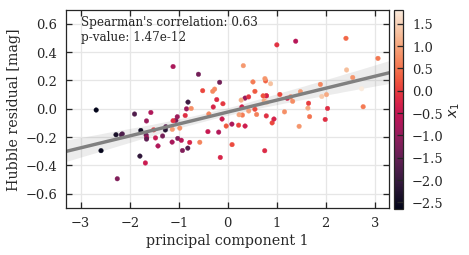

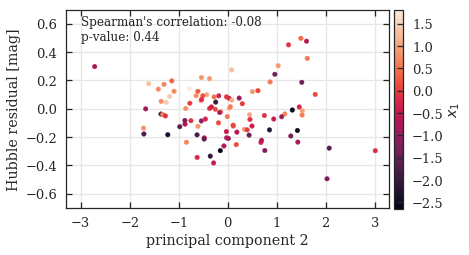

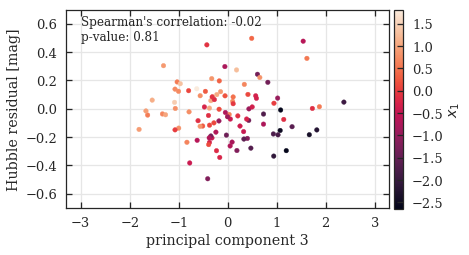

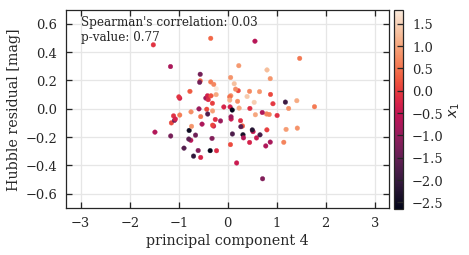

In [42]:
sns.set(context='talk', style='ticks', font='serif', color_codes=True)

for i in [0,1,2,3]:
    fig = plt.figure()
    
    #fix axes major spacing & size
    ax = plt.gca()
    ax.get_yaxis().set_major_locator(MultipleLocator(0.2))
    ax.set_ylim(-0.7, 0.7)
    ax.get_xaxis().set_major_locator(MultipleLocator(1))
    ax.set_xlim(-3.3, 3.3)

    #set axes ticks and gridlines
    ax.tick_params(axis='both', top='on', right='on', direction='in')
    ax.grid(which='major', axis='both', color='0.90', linestyle='-')
    ax.set_axisbelow(True)
    
    #show origin
#     ax.axhline(y=0, color='0.8', linewidth=2)
#     ax.axvline(x=0, color='0.8', linewidth=1)

   ## add best fit on PC_1 -- under data points
    if i==0:
#         x = np.linspace(min(principalComponents2[:,i]), max(principalComponents2[:,i]), 100)
#         print(m*x+b)
#         plt.plot(x, m*x+b)
        sns.regplot(principalComponents2[:,i], data['hr'], marker='', color='grey', ax=ax)
    
    #plot data on top -- not needed down here if we don't try to show the origin
    plt.scatter(principalComponents2[:,i], data['hr'], marker='.', c=data['x1'])
    
    
    # add axes labels, after sns.regplot
    plt.xlabel(f'principal component {i+1}')
    plt.ylabel('Hubble residual [mag]')
    
    #Add colorbar
    ##["{:>4.1f}".format(y) for y in yticks] as possible color bar formating.
    cax = fig.add_axes([0.95, 0.217, 0.02, 0.691])   # fig.set_tight_layout({'pad': 1.5})
#     cax = fig.add_axes([0.965, 0.2, 0.02, 0.691])   # plt.tight_layout()
    cax.tick_params(axis='y', direction='in')
    cax.set_axisbelow(False)   # bring tick marks above coloring
    plt.colorbar(label=r"$x_1$", cax=cax)
    
    
    #add Spearman's correlation
    ##add a back color so the grid lines do not get in the way?
    sp_r, sp_p = spearmanr(principalComponents2[:,i], data['hr'])
    if i==0:
        ax.text(-3, 0.48, f"Spearman's correlation: {sp_r:.2f}\np-value: {sp_p:.2e}", 
                {'fontsize':12})
    else:
        ax.text(-3, 0.48, f"Spearman's correlation: {sp_r:.2f}\np-value: {sp_p:.2f}", 
                {'fontsize':12})
    
    fig.set_tight_layout({'pad': 1.5})
    plt.savefig(f'HRvPC{i+1}.pdf', bbox_inches='tight')   # bbox to make space for the colorbar
    plt.show()

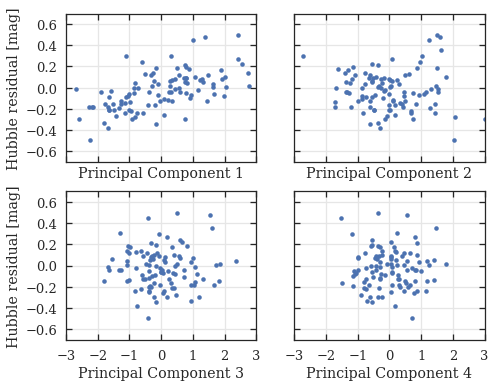

In [65]:
sns.set(context='talk', style='ticks', font='serif', color_codes=True)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(7.5, 6))

ax1.plot(principalComponents2[:,0], data['hr'], '.')
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Hubble residual [mag]')

ax2.plot(principalComponents2[:,1], data['hr'], '.')
ax2.set_xlabel('Principal Component 2')
# ax2.set_ylabel('Hubble residual [mag]')

ax3.plot(principalComponents2[:,2], data['hr'], '.')
ax3.set_xlabel('Principal Component 3')
ax3.set_ylabel('Hubble residual [mag]')

ax4.plot(principalComponents2[:,3], data['hr'], '.')
ax4.set_xlabel('Principal Component 4')
# ax4.set_ylabel('Hubble residual [mag]')

#fix axes major spacing & size
ax1.get_yaxis().set_major_locator(MultipleLocator(0.2))
ax3.get_yaxis().set_major_locator(MultipleLocator(0.2))
ax1.set_ylim(-0.7, 0.7)
ax3.set_ylim(-0.7, 0.7)
ax1.get_xaxis().set_major_locator(MultipleLocator(1))
ax2.get_xaxis().set_major_locator(MultipleLocator(1))
ax1.set_xlim(-3, 3)
ax2.set_xlim(-3, 3)

#set axes ticks and gridlines
ax1.tick_params(axis='both', top='on', right='on', direction='in')
ax1.grid(which='major', axis='both', color='0.90', linestyle='-')
ax1.set_axisbelow(True)
ax2.tick_params(axis='both', top='on', right='on', direction='in')
ax2.grid(which='major', axis='both', color='0.90', linestyle='-')
ax2.set_axisbelow(True)
ax3.tick_params(axis='both', top='on', right='on', direction='in')
ax3.grid(which='major', axis='both', color='0.90', linestyle='-')
ax3.set_axisbelow(True)
ax4.tick_params(axis='both', top='on', right='on', direction='in')
ax4.grid(which='major', axis='both', color='0.90', linestyle='-')
ax4.set_axisbelow(True)

plt.show()

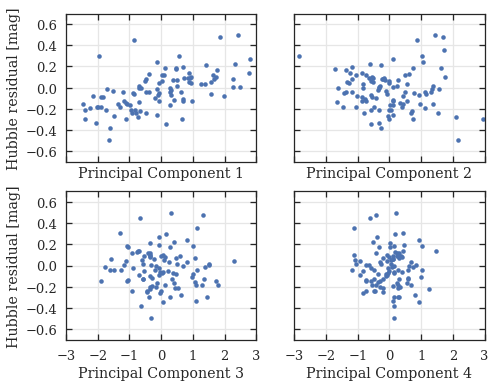

In [66]:
sns.set(context='talk', style='ticks', font='serif', color_codes=True)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(7.5, 6))

ax1.plot(principalComponents_global[:,0], data['hr'], '.')
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Hubble residual [mag]')

ax2.plot(principalComponents_global[:,1], data['hr'], '.')
ax2.set_xlabel('Principal Component 2')
# ax2.set_ylabel('Hubble residual [mag]')

ax3.plot(principalComponents_global[:,2], data['hr'], '.')
ax3.set_xlabel('Principal Component 3')
ax3.set_ylabel('Hubble residual [mag]')

ax4.plot(principalComponents_global[:,3], data['hr'], '.')
ax4.set_xlabel('Principal Component 4')
# ax4.set_ylabel('Hubble residual [mag]')

#fix axes major spacing & size
ax1.get_yaxis().set_major_locator(MultipleLocator(0.2))
ax3.get_yaxis().set_major_locator(MultipleLocator(0.2))
ax1.set_ylim(-0.7, 0.7)
ax3.set_ylim(-0.7, 0.7)
ax1.get_xaxis().set_major_locator(MultipleLocator(1))
ax2.get_xaxis().set_major_locator(MultipleLocator(1))
ax1.set_xlim(-3, 3)
ax2.set_xlim(-3, 3)

#set axes ticks and gridlines
ax1.tick_params(axis='both', top='on', right='on', direction='in')
ax1.grid(which='major', axis='both', color='0.90', linestyle='-')
ax1.set_axisbelow(True)
ax2.tick_params(axis='both', top='on', right='on', direction='in')
ax2.grid(which='major', axis='both', color='0.90', linestyle='-')
ax2.set_axisbelow(True)
ax3.tick_params(axis='both', top='on', right='on', direction='in')
ax3.grid(which='major', axis='both', color='0.90', linestyle='-')
ax3.set_axisbelow(True)
ax4.tick_params(axis='both', top='on', right='on', direction='in')
ax4.grid(which='major', axis='both', color='0.90', linestyle='-')
ax4.set_axisbelow(True)

plt.show()

Other stuff

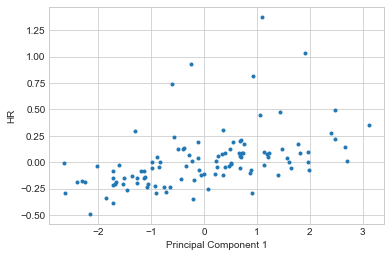

In [64]:
plt.plot(principalComponents2[:,0], data['hr'], '.')
plt.xlabel('Principal Component 1')
plt.ylabel('HR')
# plt.savefig('HRvPCA1.pdf')
plt.show()

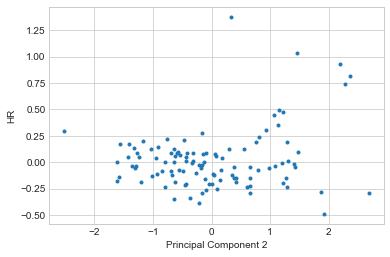

In [65]:
plt.plot(principalComponents2[:,1], data['hr'], '.')
plt.xlabel('Principal Component 2')
plt.ylabel('HR')
# plt.savefig('HRvPCA2.pdf')
plt.show()

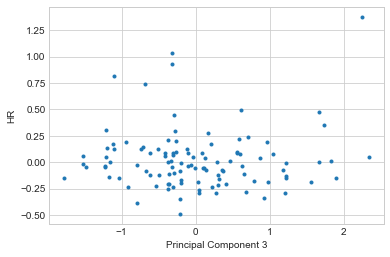

In [66]:
plt.plot(principalComponents2[:,2], data['hr'], '.')
plt.xlabel('Principal Component 3')
plt.ylabel('HR')
# plt.savefig('HRvPCA3.pdf')
plt.show()

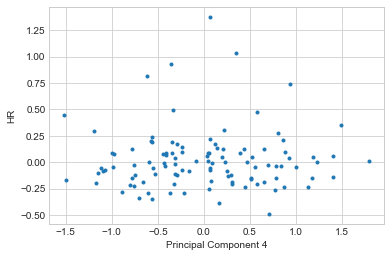

In [67]:
plt.plot(principalComponents2[:,3], data['hr'], '.')
plt.xlabel('Principal Component 4')
plt.ylabel('HR')
# plt.savefig('HRvPCA4.pdf')
plt.show()

[ 0.53352587, -0.04696966, -0.56537291, -0.62729377] of x1, color, stellar mass, and age.

* color has no effect.
* x1 shows that it is different SNIa, of our standard definitions.
* stellar mass and age have a negative correlation of almost equal weight, but age is slightly stronger.


### PCA without HR and without objects with HR < 0.5

Removes 5 objects

In [ ]:
data[data['hr']>=0.5]['hr']

In [57]:
features = ['x1', 'color', 'stellar mass', 'age']
z = data[data['hr']<0.5].loc[:, features].values
z = StandardScaler().fit_transform(z)
z.shape

(103, 4)

In [58]:
pca3 = PCA(n_components=4)
principalComponents3 = pca3.fit_transform(z)

In [60]:
pca3.components_

array([[ 0.54259113, -0.10542863, -0.56066036, -0.61655465],
       [-0.16048507,  0.95949048, -0.1897051 , -0.13279506],
       [-0.73930618, -0.25248866, -0.622891  , -0.04102012],
       [ 0.36505586,  0.06717357, -0.51154544,  0.77494722]])

In [61]:
pca3.singular_values_

array([ 13.5253809 ,  10.21837964,   8.49723135,   7.2419506 ])

In [72]:
pca3.explained_variance_ratio_

array([ 0.44401924,  0.25343515,  0.17524986,  0.12729575])

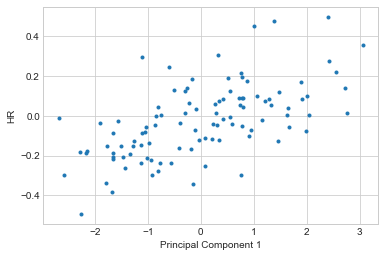

In [73]:
plt.plot(principalComponents3[:,0], data[data['hr']<0.5]['hr'], '.')
plt.xlabel('Principal Component 1')
plt.ylabel('HR')
plt.savefig('HRvPCA1.pdf')
plt.show()

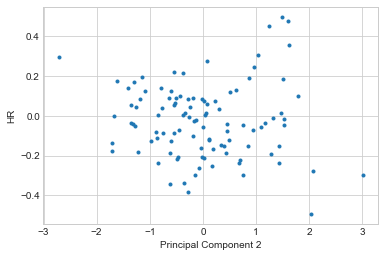

In [74]:
plt.plot(principalComponents3[:,1], data[data['hr']<0.5]['hr'], '.')
plt.xlabel('Principal Component 2')
plt.ylabel('HR')
plt.savefig('HRvPCA2.pdf')
plt.show()

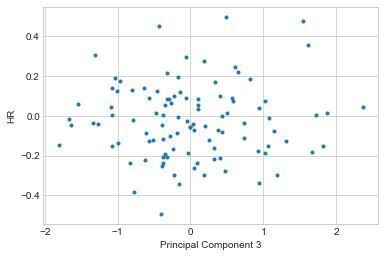

In [75]:
plt.plot(principalComponents3[:,2], data[data['hr']<0.5]['hr'], '.')
plt.xlabel('Principal Component 3')
plt.ylabel('HR')
plt.savefig('HRvPCA3.pdf')
plt.show()

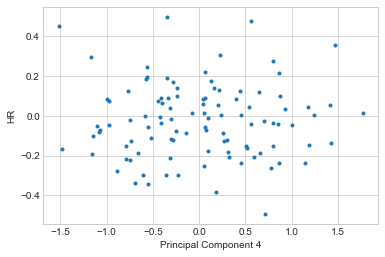

In [76]:
plt.plot(principalComponents3[:,3], data[data['hr']<0.5]['hr'], '.')
plt.xlabel('Principal Component 4')
plt.ylabel('HR')
plt.savefig('HRvPCA4.pdf')
plt.show()

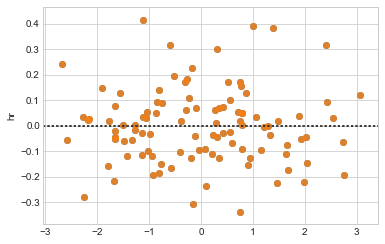

In [81]:
sns.residplot(principalComponents3[:,0], data[data['hr']<0.5]['hr'])
plt.show()